In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from preprocessing import *
from cnn_models import *
from datetime import datetime

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


#### Overview
The goal here is to use the CNN to reduce the size of the input image to obtain a "discretized" image of shape, e.g. (W/16, H/16). Every entry of this image is related to a patch in the input image. This obtained image is compared by the CNN with the groundtruth (after properly discretizing by it patch-wise).

### - Load data

In [2]:
# Loaded a set of images
n = 10

imgs, gt_imgs = load_images(n)
imgs[0].shape, gt_imgs[0].shape

Loading 10 images


((400, 400, 3), (400, 400))

### - Reshape the data
We reshape each input to fulfill our cnn inputs and output shape.

In [3]:
# !!! set predict_patch_width in accordance to the model you are using !!!
# the shape of the output of the model depends on the strides parameters 
# (if a layer has stride=2 then each ouput's side is half of the input'side).
# predict_patch_width must be equal to the total reduction of the model, e.g.
# if the model has three layer with stride=2 => the input of the model is 
# reduced by a factor of 2*2*2=8, i.e. the ouptut will be patch-wise with 
# patches 8x8 pixels.
predict_patch_width = 8

X, Y = images_to_XY(imgs, gt_imgs, predict_patch_width=predict_patch_width)

set_ = SimpleNamespace()
set_.X = X
set_.Y = Y

X.shape, Y.shape

((10, 400, 400, 3), (10, 50, 50))

### - For now avoid cross validation, just split the datasest in test and train. 

In [4]:
test_ratio = 0.5

train, test = split_train_test(X, Y, test_ratio=test_ratio, seed=1)
train.X.shape, train.Y.shape, test.X.shape, test.Y.shape 

((5, 400, 400, 3), (5, 50, 50), (5, 400, 400, 3), (5, 50, 50))

In [ ]:
# # check it makes sense (show the i-th input of set_)
# i = 0
# set_ = test

# fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# axs[0].imshow(set_.Y[i, :, :, 1], cmap='gray')
# axs[1].imshow(set_.X[i, :, :])

### - Build the CNN model or load a previous one

- Choose one of the models you defined (with model_n) and initialize it.

In [7]:
# generate an unique name for the model (so to avoid overwriting previous models)
folder_name = "model_"+str('{0:%Y-%m-%d_%H:%M:%S}'.format(datetime.now()))
model_path = "models/"+folder_name
model = CnnModel(model_n=0, model_path=model_path)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 32)    11648     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, None, None, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 32)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 48)    38448     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, None, None, 48)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 48)    57648     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, None, None, 48)    0         
__________

- Otherwise load a previous model

In [66]:
# give the folder
folder_name = "model_2017-12-11_11:51:54"
model_path = "models/"+folder_name
model = CnnModel(model_path=model_path)
model.load() # load the model and its weights
model.summary()

Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 32)    11648     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, None, None, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 32)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 48)    38448     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, None, None, 48)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 48)    57648     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, None, None, 48)  

### - Train the model on the train data while validating it on the test data

In [ ]:
# pass a batch size which is a factor of train.shape[0] so that all the batches are fo the same size
num_epochs=10
batch_size=5
model.train(train, test=None, num_epochs=num_epochs, batch_size=batch_size, monitor='loss') 

#### Plot the accuracy and the loss obtained during training

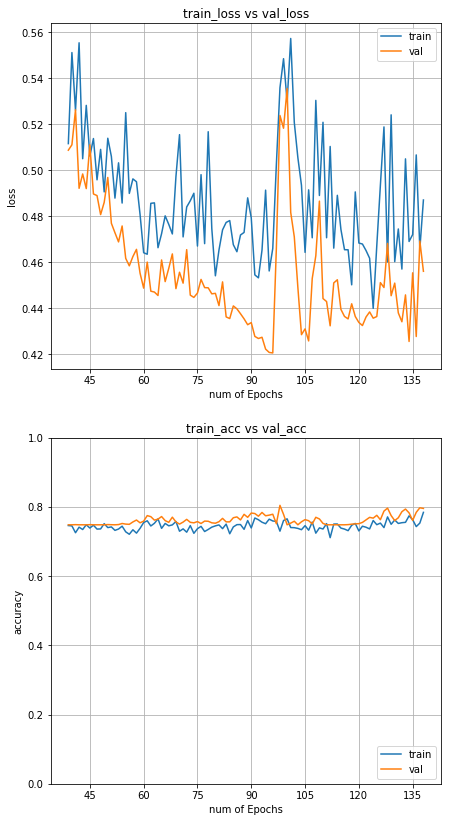

In [81]:
last_epochs=100 # plot only the last n epochs
model.plot_history(last_epochs=last_epochs)

#### Display the output of a specific layer

In [ ]:
# these are all the layers 
model.model.layers

feature_maps (output of layer 8): (50, 50, 64)


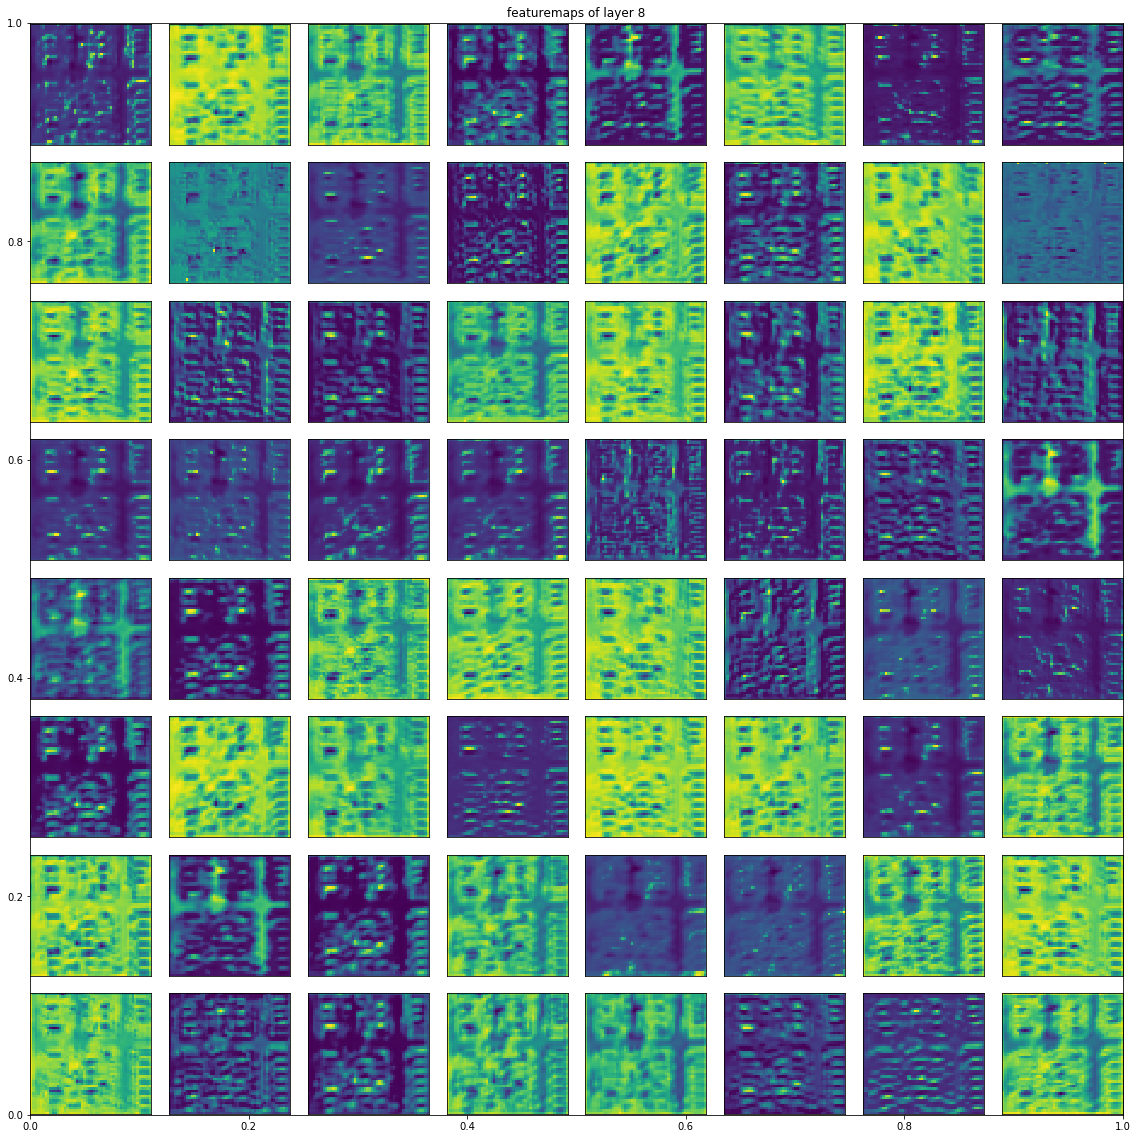

In [82]:
# choose a layer and an image 
image = test.X[0]
layer_num = 8

model.show_layer_output(image, layer_num, filename="") # pass a filename if you want to store the image to file 

### - Evaluate the model on the test data

                precision    recall  f1-score   support

0 (background)       0.81      0.94      0.87      9247
      1 (road)       0.66      0.36      0.47      3253

   avg / total       0.77      0.79      0.76     12500

Confusion matrix, without normalization


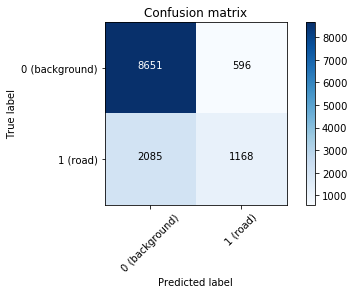

Normalized confusion matrix


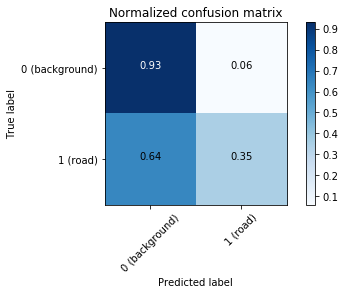

In [68]:
# check the performance on train or test
set_ = train

model.evaluate_model(set_.X, set_.Y)

### - Show a prediction

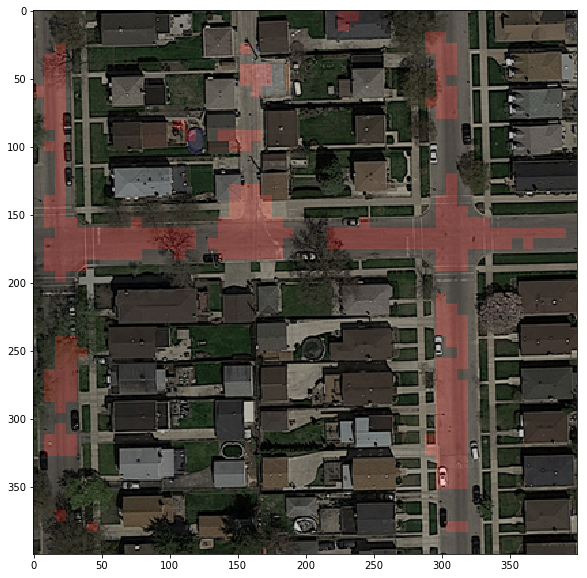

In [95]:
# choose an image to predict (or part of it)
img = test.X[0][:, :]

model.display_prediction(img, ax=None)

### - Save/load model

In [91]:
model.save()

Saved model to disk


### - Others

In [ ]:
# some callbacks example: 

# create a list of callbacks we want to use during training
# # a callback to store epoch results to a csv file
# filename='model_train_new.csv'
# csv_log = callbacks.CSVLogger(filename, separator=',', append=False)

# # a callback to stob before doing the predefined number of epochs (stop before overfitting the data)
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='min')

# # a callback to save the best model (best model = the one with the lowest 'monitor' variable)
# filepath = "best-weights-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"
# checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# # callbacks_list = [csv_log,early_stopping,checkpoint]

print(
    "-get configurations:", "\n",
    model.get_config(), "\n",
    model.layers[0].get_config(), "\n",

    "\n-get shapes", "\n",
    model.layers[0].input_shape, "\n",
    model.layers[0].output_shape, "\n",
    
    "\n-get weights", "\n",
    model.layers[0].get_weights()[0].shape, "\n",
    
    "\n-check if trainable", "\n",
    model.layers[0].trainable, "\n", # you can set this to false to "freeze" a layer
)

In [ ]:
from IPython.core.debugger import Pdb
debugger = Pdb()
debugger.set_trace() # put this line as a breakpoint

Test batch generation

In [71]:
from cnn_models import image_generators, combine_generators
j = 0
x_batches = []
y_batches = []
generator_rot90k, generator_rot360 = image_generators(X[:1], Y[:1], batch_size = 4)
for x, y in combine_generators(generator_rot90k, generator_rot360, prob_gen1=0.8):
    j += 1
    if j > 20:
        break
    x_batches.append(x)
    y_batches.append(y)


Generated x and y batch of sizes:  (1, 400, 400, 3) (1, 50, 50, 1)

Generated x and y batch of sizes:  (1, 400, 400, 3) (1, 50, 50, 1)

Generated x and y batch of sizes:  (1, 400, 400, 3) (1, 50, 50, 1)

Generated x and y batch of sizes:  (1, 400, 400, 3) (1, 50, 50, 1)

Generated x and y batch of sizes:  (1, 400, 400, 3) (1, 50, 50, 1)

Generated x and y batch of sizes:  (1, 400, 400, 3) (1, 50, 50, 1)

Generated x and y batch of sizes:  (1, 400, 400, 3) (1, 50, 50, 1)

Generated x and y batch of sizes:  (1, 400, 400, 3) (1, 50, 50, 1)

Generated x and y batch of sizes:  (1, 400, 400, 3) (1, 50, 50, 1)

Generated x and y batch of sizes:  (1, 400, 400, 3) (1, 50, 50, 1)

Generated x and y batch of sizes:  (1, 400, 400, 3) (1, 50, 50, 1)

Generated x and y batch of sizes:  (1, 400, 400, 3) (1, 50, 50, 1)

Generated x and y batch of sizes:  (1, 400, 400, 3) (1, 50, 50, 1)

Generated x and y batch of sizes:  (1, 400, 400, 3) (1, 50, 50, 1)

Generated x and y batch of sizes:  (1, 400, 400

In [76]:
b = 0

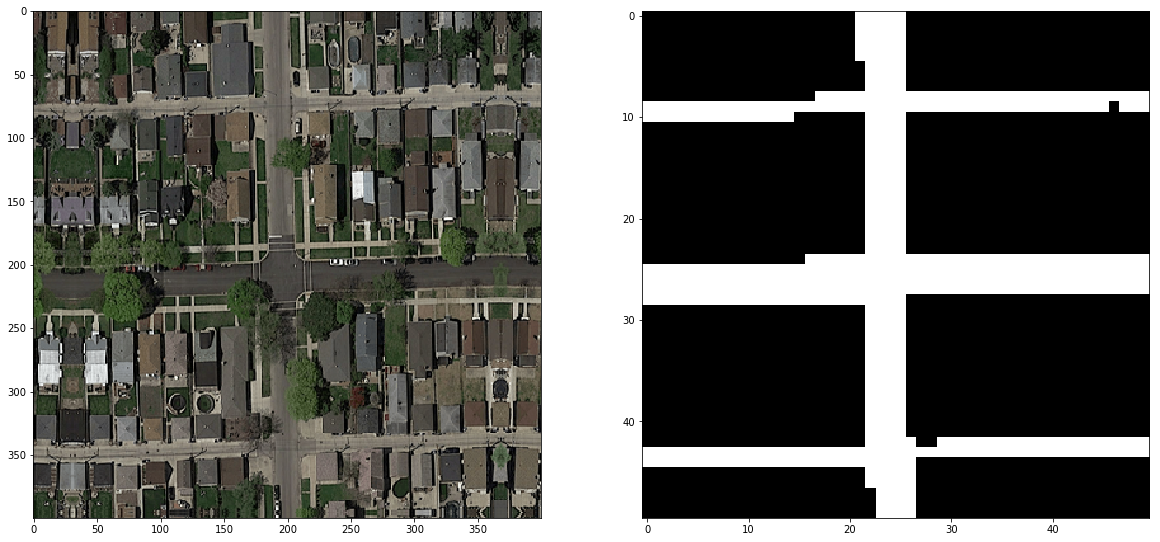

In [80]:
i = 0
b += 1
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((20, 10))
axs[0].imshow(x_batches[b][i], cmap='gray')
axs[1].imshow(y_batches[b][i][:, :, 1], cmap='gray')